This example is a breakdown of the train code released with pytorch-CycleGAN-and-pix2pix.  It's less generic - I'm only including the ResNet implementation, and using their default options from the actual code.  Also simplified it to assume you're running on a single GPU at most.

### Generator Network

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import numpy as np
import random
import itertools

In [2]:
# Define a resnet block, using reflective padding and InstanceNorm
class ResnetBlock(nn.Module):
    def __init__(self, dim, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, use_bias)
    def build_conv_block(self, dim, use_bias):
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]
        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [3]:
# Defines the generator that consists of Resnet blocks between a few
# downsampling/upsampling operations.
# Code and idea originally from Justin Johnson's architecture.
# https://github.com/jcjohnson/fast-neural-style/
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64):
        super(ResnetGenerator, self).__init__()
        use_bias = True
        n_downsampling = 2
        n_blocks = 9

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if hasattr(m.bias, 'data'):
            m.bias.data.fill_(0)

In [5]:
# create generator network
def define_G(input_nc, output_nc, ngf):
    netG = ResnetGenerator(input_nc, output_nc, ngf)
    netG.apply(weights_init)
    return netG

### Discriminator Network

In [6]:
# Defines the PatchGAN discriminator with the specified arguments.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(NLayerDiscriminator, self).__init__()
        use_bias = True
        kw = 4
        padw = int(np.ceil((kw-1)/2))
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

In [7]:
def define_D(input_nc, ndf, n_layers_D=3):
    netD = NLayerDiscriminator(input_nc, ndf, n_layers=3)
    netD.apply(weights_init)
    return netD

### Loss Function

In [94]:
# Defines the GAN loss which uses either LSGAN or the regular GAN.
# When LSGAN is used, it is basically same as MSELoss,
# but it abstracts away the need to create the target label tensor
# that has the same size as the input
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        self.real_label_var = None
        self.fake_label_var = None
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            create_label = ((self.real_label_var is None) or
                            (self.real_label_var.numel() != input.numel()))
            if create_label:
                real_tensor = torch.FloatTensor(input.size()).fill_(self.real_label)
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = ((self.fake_label_var is None) or
                            (self.fake_label_var.numel() != input.numel()))
            if create_label:
                fake_tensor = torch.FloatTensor(input.size()).fill_(self.fake_label)
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        if torch.cuda.is_available():
            target_tensor = target_tensor.cuda()
        return target_tensor

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)

### Image Pool

In [9]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

### CycleGAN

In [10]:
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

In [101]:
class CycleGANModel(object):
    def initialize(self, isTrain = True):
        self.nb = 1 # batch size
        self.size = 256 # crop size
        self.input_nc = 3 # number of input channels
        self.output_nc = 3 # number of output channels
        self.ngf = 64 # number of generative filters in the first conv layer
        self.ndf = 64 # number of discriminative filters in the first conv layer
        self.pool_size = 50 # size of image buffer that stores previously generated images
        self.lr = 0.0002 # initial learning rate for Adam
        self.old_lr = 0.0002 # initial learning rate for Adam
        self.beta1 = 0.5 # momentum term for Adam
        self.identity = 0.0 # use identity mapping. Setting identity other than 1 has an effect of scaling the weight of the identity mapping loss. For example, if the weight of the identity loss should be 10 times smaller than the weight of the reconstruction loss, please set optidentity = 0.1
        self.lambda_A = 10.0 # weight for cycle loss (A -> B -> A)
        self.lambda_B = 10.0 # weight for cycle loss (B -> A -> B)
        self.checkpoint_dir = 'checkpoints'
        
        # inputs
        self.input_A = torch.FloatTensor(self.nb, self.input_nc, self.size, self.size)
        self.input_B = torch.FloatTensor(self.nb, self.output_nc, self.size, self.size)

        # generators
        self.netG_A = define_G(self.input_nc, self.output_nc, self.ngf)
        self.netG_B = define_G(self.output_nc, self.input_nc, self.ngf)
        if torch.cuda.is_available():
            self.netG_A.cuda()
            self.netG_B.cuda()

        if isTrain:
            # discriminators
            self.netD_A = define_D(self.output_nc, self.ndf)
            self.netD_B = define_D(self.input_nc, self.ndf)
            if torch.cuda.is_available():
                self.netD_A.cuda()
                self.netD_B.cuda()
            
            self.fake_A_pool = ImagePool(self.pool_size)
            self.fake_B_pool = ImagePool(self.pool_size)
            # define loss functions
            self.criterionGAN = GANLoss(use_lsgan=True)
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()

            # initialize optimizers
            self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()),
                                                lr=self.old_lr, betas=(self.beta1, 0.999))
            self.optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(), lr=self.old_lr, betas=(self.beta1, 0.999))
            self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=self.old_lr, betas=(self.beta1, 0.999))
            self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=self.old_lr, betas=(self.beta1, 0.999))

        print('---------- Networks initialized -------------')
        print_network(self.netG_A)
        print_network(self.netG_B)
        if isTrain:
            print_network(self.netD_A)
            print_network(self.netD_B)
        print('-----------------------------------------------')

    def set_input(self, input):
        input_A = input['A']
        input_B = input['B']
        self.input_A.resize_(input_A.size()).copy_(input_A)
        self.input_B.resize_(input_B.size()).copy_(input_B)
        self.image_paths = input['A_paths']

    def forward(self):
        self.real_A = Variable(self.input_A)
        self.real_B = Variable(self.input_B)
        if torch.cuda.is_available():
            self.real_A = self.real_A.cuda()
            self.real_B = self.real_B.cuda()

    def test(self):
        self.real_A = Variable(self.input_A, volatile=True)
        self.real_B = Variable(self.input_B, volatile=True)
        if torch.cuda.is_available():
            self.real_A = self.real_A.cuda()
            self.real_B = self.real_B.cuda()

        self.fake_B = self.netG_A.forward(self.real_A)
        self.rec_A = self.netG_B.forward(self.fake_B)

        self.fake_A = self.netG_B.forward(self.real_B)
        self.rec_B = self.netG_A.forward(self.fake_A)

    # get image paths
    def get_image_paths(self):
        return self.image_paths

    def backward_D_basic(self, netD, real, fake):
        # Real
        pred_real = netD.forward(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD.forward(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        # backward
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)

    def backward_D_B(self):
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)

    def backward_G(self):
        lambda_idt = self.identity
        lambda_A = self.lambda_A
        lambda_B = self.lambda_B
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed.
            self.idt_A = self.netG_A.forward(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed.
            self.idt_B = self.netG_B.forward(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss
        # D_A(G_A(A))
        self.fake_B = self.netG_A.forward(self.real_A)
        pred_fake = self.netD_A.forward(self.fake_B)
        self.loss_G_A = self.criterionGAN(pred_fake, True)
        # D_B(G_B(B))
        self.fake_A = self.netG_B.forward(self.real_B)
        pred_fake = self.netD_B.forward(self.fake_A)
        self.loss_G_B = self.criterionGAN(pred_fake, True)
        # Forward cycle loss
        self.rec_A = self.netG_B.forward(self.fake_B)
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss
        self.rec_B = self.netG_A.forward(self.fake_A)
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()

    def optimize_parameters(self):
        # forward
        self.forward()
        # G_A and G_B
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()
        # D_A
        self.optimizer_D_A.zero_grad()
        self.backward_D_A()
        self.optimizer_D_A.step()
        # D_B
        self.optimizer_D_B.zero_grad()
        self.backward_D_B()
        self.optimizer_D_B.step()

    def get_current_errors(self):
        D_A = self.loss_D_A.data[0]
        G_A = self.loss_G_A.data[0]
        Cyc_A = self.loss_cycle_A.data[0]
        D_B = self.loss_D_B.data[0]
        G_B = self.loss_G_B.data[0]
        Cyc_B = self.loss_cycle_B.data[0]
        if self.identity > 0.0:
            idt_A = self.loss_idt_A.data[0]
            idt_B = self.loss_idt_B.data[0]
            return OrderedDict([('D_A', D_A), ('G_A', G_A), ('Cyc_A', Cyc_A), ('idt_A', idt_A),
                                ('D_B', D_B), ('G_B', G_B), ('Cyc_B', Cyc_B), ('idt_B', idt_B)])
        else:
            return OrderedDict([('D_A', D_A), ('G_A', G_A), ('Cyc_A', Cyc_A),
                                ('D_B', D_B), ('G_B', G_B), ('Cyc_B', Cyc_B)])

    def get_current_visuals(self):
        real_A = util.tensor2im(self.real_A.data)
        fake_B = util.tensor2im(self.fake_B.data)
        rec_A = util.tensor2im(self.rec_A.data)
        real_B = util.tensor2im(self.real_B.data)
        fake_A = util.tensor2im(self.fake_A.data)
        rec_B = util.tensor2im(self.rec_B.data)
        if self.identity > 0.0:
            idt_A = util.tensor2im(self.idt_A.data)
            idt_B = util.tensor2im(self.idt_B.data)
            return OrderedDict([('real_A', real_A), ('fake_B', fake_B), ('rec_A', rec_A), ('idt_B', idt_B),
                                ('real_B', real_B), ('fake_A', fake_A), ('rec_B', rec_B), ('idt_A', idt_A)])
        else:
            return OrderedDict([('real_A', real_A), ('fake_B', fake_B), ('rec_A', rec_A),
                                ('real_B', real_B), ('fake_A', fake_A), ('rec_B', rec_B)])

    def save(self, label):
        self.save_network(self.netG_A, 'G_A', label)
        self.save_network(self.netD_A, 'D_A', label)
        self.save_network(self.netG_B, 'G_B', label)
        self.save_network(self.netD_B, 'D_B', label)

    def update_learning_rate(self, niter_decay):
        lrd = self.lr / niter_decay
        lr = self.old_lr - lrd
        for param_group in self.optimizer_D_A.param_groups:
            param_group['lr'] = lr
        for param_group in self.optimizer_D_B.param_groups:
            param_group['lr'] = lr
        for param_group in self.optimizer_G.param_groups:
            param_group['lr'] = lr

        print('update learning rate: %f -> %f' % (self.old_lr, lr))
        self.old_lr = lr
    
    def save_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.checkpoint_dir, save_filename)
        torch.save(network.cpu().state_dict(), save_path)
        if torch.cuda.is_available():
            network.cuda()

    # helper loading function that can be used by subclasses
    def load_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.save_dir, save_filename)
        network.load_state_dict(torch.load(save_path))

### Training Data

In [78]:
%%bash
if [ ! -d datasets/maps ]; then
./datasets/download_cyclegan_dataset.sh maps
fi

In [58]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
from glob import glob

class MapsDataset(Dataset):
    def __init__(self, mode):
        self.img_paths_A = glob(os.path.join('datasets/maps', mode+'A', '*.jpg'))
        self.img_paths_B = glob(os.path.join('datasets/maps', mode+'B', '*.jpg'))
        self.img_paths_A = sorted(self.img_paths_A)
        self.img_paths_B = sorted(self.img_paths_B)
        self.A_size = len(self.img_paths_A)
        self.B_size = len(self.img_paths_B)
        self.dataset_size = max(self.A_size, self.B_size)
        self.transform = self.get_transform()
        
    def __getitem__(self, index):
        index_A = index % self.A_size
        index_B = random.randint(0, self.B_size-1)
        
        img_path_A = self.img_paths_A[index_A]
        img_path_B = self.img_paths_B[index_B]
        
        raw_img_A = Image.open(img_path_A).convert('RGB')
        raw_img_B = Image.open(img_path_B).convert('RGB')
        img_A = self.transform(raw_img_A)
        img_B = self.transform(raw_img_B)
        
        return {'A': img_A, 'B': img_B, 
                'A_paths': img_path_A, 'B_paths': img_path_B,
                'raw_A': np.asarray(raw_img_A), 'raw_B': np.asarray(raw_img_B)}
    
    def __len__(self):
        return self.dataset_size
    
    def get_transform(self):
        load_size = 286
        fine_size = 256
        transform_list = [transforms.Scale((load_size, load_size), Image.BICUBIC),
                          transforms.RandomCrop(fine_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        return transforms.Compose(transform_list)
        
    def name(self):
        return "MapsDataset"

In [81]:
maps_dataset = MapsDataset('train')
maps_dataloader = DataLoader(maps_dataset, batch_size=1, shuffle=True)
print('Number of training images: ' + str(len(maps_dataloader)))

Number of training images: 1096


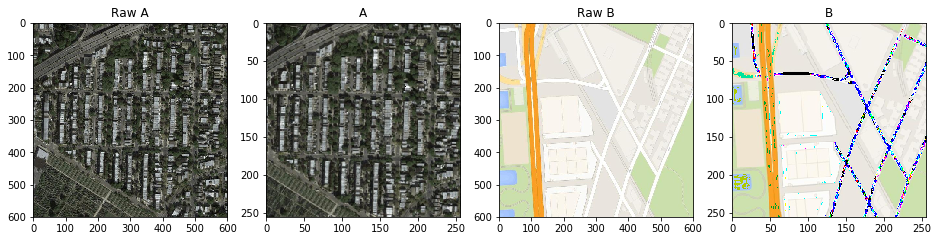

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt

def unnorm(x):
    un_x = 255*(x*0.5-0.5)
    return un_x.astype(np.uint8)

# visualize to check images
test_datum = next(iter(maps_dataloader))
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(test_datum['raw_A'][0].numpy())
plt.title('Raw A')
plt.subplot(1,4,2)
plt.imshow(unnorm(test_datum['A'][0].numpy()).transpose(1,2,0))
plt.title('A')
plt.subplot(1,4,3)
plt.imshow(test_datum['raw_B'][0].numpy())
plt.title('Raw B')
plt.subplot(1,4,4)
plt.imshow(unnorm(test_datum['B'][0].numpy()).transpose(1,2,0))
plt.title('B')

### Train

In [102]:
model = CycleGANModel()
model.initialize(isTrain=True)

---------- Networks initialized -------------
ResnetGenerator (
  (model): Sequential (
    (0): ReflectionPad2d (3, 3, 3, 3)
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False)
    (3): ReLU (inplace)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
    (6): ReLU (inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
    (9): ReLU (inplace)
    (10): ResnetBlock (
      (conv_block): Sequential (
        (0): ReflectionPad2d (1, 1, 1, 1)
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
        (3): ReLU (inplace)
        (4): ReflectionPad2d (1, 1, 1, 1)
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): Inst

In [ ]:
niter = 100 # number of iterations at starting learning rate
niter_decay = 100 # number of iterations to linearly decay learning rate to zero
for epoch in range(1, niter+niter_decay+1):
    for i, data in enumerate(maps_dataloader):
        model.set_input(data)
        model.optimize_parameters()
        if i % 100 == 0:
            print('saving the latest model (epoch %d, iter %d)' % (epoch, i))
            model.save('latest')
    if epoch > niter_decay:
        model.update_learning_rate(niter_decay)


saving the latest model (epoch 1, iter 0)
saving the latest model (epoch 1, iter 100)
saving the latest model (epoch 1, iter 200)
saving the latest model (epoch 1, iter 300)
